In [11]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
from segment_transform import SegmentImage

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(device)

cpu


In [13]:
train_dir = "../dataset/archive/archive (7)/train_data"
test_dir = "../dataset/archive/archive (7)/test_data"
val_dir = "../dataset/archive/archive (7)/validation_data"

In [14]:
from torchvision.transforms import v2
mtcnn = MTCNN(keep_all=True, device=device)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    
    SegmentImage(mtcnn=mtcnn),
    v2.Normalize(mean=mean, std=std),
])



trainset =  torchvision.datasets.ImageFolder(train_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
valset = torchvision.datasets.ImageFolder(val_dir, transform=transform)

In [15]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

classes = ('drowsy', 'notdrowsy')

tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1])
torch.Size([16, 3, 299, 299])


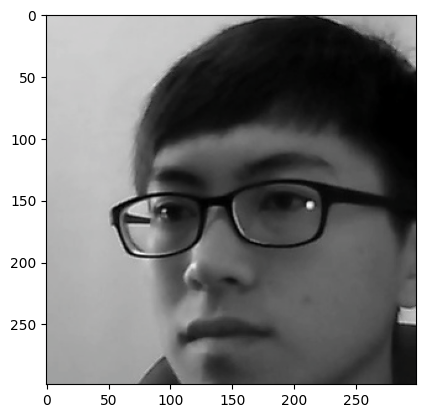

In [16]:
def imshow(img):
    inv_normalize = v2.Normalize(mean=-mean/std, std=1/std)  # Adjust means and stds if different
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(labels)
print(images[0].shape)
imshow(images[0][2])


In [17]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Step 1: Load pre-trained InceptionV3 model
inception_eye = models.inception_v3(pretrained=True)

num_ftrs = inception_eye.AuxLogits.fc.in_features
inception_eye.AuxLogits.fc = nn.Linear(num_ftrs, 2)

num_ftrs = inception_eye.fc.in_features
inception_eye.fc = nn.Linear(num_ftrs, 2)

inception_eye.load_state_dict(torch.load("./weights/eye.pth", map_location=torch.device('cpu')))

inception_eye.fc = nn.Identity()
inception_eye.AuxLogits.fc = nn.Identity()

# Step 2: Freeze all parameters except the classification layers
for param in inception_eye.parameters():
    param.requires_grad = False

inception_eye.eval()

# Step 1: Load pre-trained InceptionV3 model
inception_mouth = models.inception_v3(pretrained=True)

num_ftrs = inception_mouth.AuxLogits.fc.in_features
inception_mouth.AuxLogits.fc = nn.Linear(num_ftrs, 2)

num_ftrs = inception_mouth.fc.in_features
inception_mouth.fc = nn.Linear(num_ftrs, 2)

inception_mouth.load_state_dict(torch.load("./weights/mouth.pth", map_location=torch.device('cpu')))

inception_mouth.fc = nn.Identity()
inception_mouth.AuxLogits.fc = nn.Identity()

# Step 2: Freeze all parameters except the classification layers
for param in inception_mouth.parameters():
    param.requires_grad = False

inception_mouth.eval()



c:\Users\ayesh\anaconda3\envs\DDD\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ayesh\anaconda3\envs\DDD\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [18]:
outputs = inception_mouth(images[0])

outputs_eye = inception_eye(images[0])

outputs_eye.shape

torch.Size([16, 2048])

In [19]:

import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4096, 1536)
        self.fc2 = nn.Linear(1536, 1000)
        self.fc3 = nn.Linear(1000, 2)

    def forward(self, x):
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

classifier = Classifier()
classifier.load_state_dict(torch.load("./weights/classifier.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
from torchmetrics import Accuracy, Precision, Recall, F1Score
# Assuming you have these from your original code:
num_classes = 2

correct = 0
total = 0

# Since we're not training, we don't need to calculate gradients
with torch.no_grad():
    accuracy_metric = Accuracy(task="binary", num_classes=num_classes)  # Create accuracy metric
    precision_metric = Precision(task='binary', num_classes=num_classes, average='macro')  # Macro average for precision
    recall_metric = Recall(task='binary', num_classes=num_classes, average='macro')  # Macro average for recall
    f1_score_metric = F1Score(task='binary', num_classes=num_classes, average='macro')  # Macro average for F1-score

    for data in testloader:
        inputs_eye, labels = data[0][0].to(device), data[1].to(device)
        inputs_mouth, _ = data[0][1].to(device), data[1].to(device)
        features_eye = inception_eye(inputs_eye)
        features_mouth = inception_mouth(inputs_mouth)
        concatenated_features = torch.cat((features_eye, features_mouth), dim=1)
        outputs = classifier(concatenated_features)
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update metrics
        accuracy_metric.update(predicted, labels)
        precision_metric.update(predicted, labels)
        recall_metric.update(predicted, labels)
        f1_score_metric.update(predicted, labels)

# Print overall metrics
print(f'Accuracy of the network on the test images: {accuracy_metric.compute():.4f}')
print(f'Macro Precision: {precision_metric.compute():.4f}')
print(f'Macro Recall: {recall_metric.compute():.4f}')
print(f'Macro F1-Score: {f1_score_metric.compute():.4f}')
